# Twitter Crawling & Sentiment Analysis 

## Import Library

In [1]:
import tweepy
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline

## Akses Twitter API 

In [2]:
#Variables that contains the credentials to access Twitter API
ACCESS_TOKEN = '706085526420353025-ZY9wTf0Bu7iFKD6CvS80L9JSljOGsSw'
ACCESS_SECRET = 'qwuFvQLjNXil79z1vgGAGuWoFsarrJdkmvZOY7f35mYGL'
CONSUMER_KEY = 'Vd3Msh44t2n1ehuMIYaJvbfJJ'
CONSUMER_SECRET = 'J7IbPlgSKmwtBsnvZEZrcennD83jzirJ7DGSOATvD4EYvyGBHj'

#setup access to API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth)
    return api

#create API object
api = connect_to_twitter_OAuth()

## Crawling

In [3]:
result = api.search(q='Impeachment')

len(result)

15

In [4]:
tweet = result[0] #Get the first tweet in the result

# Analyze the data in one tweet to see what we require
for param in dir(tweet):
#The key names beginning with an '_' are hidden ones and usually 
#not required, so we'll skip them
    if not param.startswith("_"):
        print ("%s : %s\n"% (param, eval('tweet.'+param)))

author : User(_api=<tweepy.api.API object at 0x0000022E416E85F8>, _json={'id': 976623871993376768, 'id_str': '976623871993376768', 'name': 'Kriste Kline', 'screen_name': 'KristeKline', 'location': 'Georgia, USA', 'description': 'School bus driver,neccessary trouble maker', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 1227, 'friends_count': 1921, 'listed_count': 2, 'created_at': 'Thu Mar 22 00:57:30 +0000 2018', 'favourites_count': 400412, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 43410, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_image_url_https': None, 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1184650770811097088/IIaIqYsf_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.

In [5]:
results = []

#Get the first 5000 items based on the search query
for tweet in tweepy.Cursor(api.search, q='impeachment').items(100):
    results.append(tweet)

# Verify the number of items returned
print (len(results))

100


In [6]:
def toDataFrame(tweets):

    DataSet = pd.DataFrame()

    DataSet['tweetID'] = [tweet.id for tweet in tweets]
    DataSet['tweetText'] = [tweet.text for tweet in tweets]
    DataSet['tweetRetweetCt'] = [tweet.retweet_count for tweet 
    in tweets]
    DataSet['tweetFavoriteCt'] = [tweet.favorite_count for tweet 
    in tweets]
    DataSet['tweetSource'] = [tweet.source for tweet in tweets]
    DataSet['tweetCreated'] = [tweet.created_at for tweet in tweets]


    DataSet['userID'] = [tweet.user.id for tweet in tweets]
    DataSet['userScreen'] = [tweet.user.screen_name for tweet 
    in tweets]
    DataSet['userName'] = [tweet.user.name for tweet in tweets]
    DataSet['userCreateDt'] = [tweet.user.created_at for tweet 
    in tweets]
    DataSet['userDesc'] = [tweet.user.description for tweet in tweets]
    DataSet['userFollowerCt'] = [tweet.user.followers_count for tweet 
    in tweets]
    DataSet['userFriendsCt'] = [tweet.user.friends_count for tweet 
    in tweets]
    
    DataSet['userLocation'] = [tweet.user.location for tweet in tweets]
    DataSet['userTimezone'] = [tweet.user.time_zone for tweet 
    in tweets]

    return DataSet
DataSet = toDataFrame(results)

In [7]:
DataSet.head(5)

,tweetID,tweetText,tweetRetweetCt,tweetFavoriteCt,tweetSource,tweetCreated,userID,userScreen,userName,userCreateDt,userDesc,userFollowerCt,userFriendsCt,userLocation,userTimezone
0,1198465840984788992,RT @Shem_Infinite: I never though the Senate G...,16,0,Twitter for iPhone,2019-11-24 04:58:17,751834110633635840,SophistsAwake,Sophist⭐️⭐️⭐️,2016-07-09 17:43:15,Prolife Patriot doing my part to KAG. Sarcasm ...,13884,13865,,None
1,1198465840221446144,RT @JohnRMoffitt: The US Constitution provides...,27,0,Twitter for iPhone,2019-11-24 04:58:17,761725622603411456,3rdViv,Impressions🐾,2016-08-06 00:48:35,#TheResistance #MakeAmericaGreenAgain #ACLU#BL...,6344,6596,"Fort Myers, FL",None
2,1198465839290339330,RT @DiamondandSilk: Rep Jordan: Impeachment Is...,910,0,Twitter for Android,2019-11-24 04:58:17,1923990811,rrwalshjr63,Raymond R Walsh Jr,2013-10-01 16:40:06,,182,503,,None
3,1198465839097401349,RT @EricLiptonNYT: New Documents Reveal Detail...,997,0,Twitter for iPhone,2019-11-24 04:58:17,113390837,cailloudepluie,Pat Dunbar,2010-02-11 16:14:37,Happily-married. Happily-mommied. Political na...,176,384,,None
4,1198465838824775680,RT @charliekirk11: Difference between left and...,10583,0,Twitter for iPhone,2019-11-24 04:58:17,855179586,blaiseme1,DregKateWarrior,2012-09-30 18:51:26,Steeler Mama #MAGA2020 Trump Supporter #Christ...,4514,5211,USA,None


## Menyimpan Dataset Hasil crawling

In [8]:
DataSet.to_excel("impeachment.xlsx")

## Cleaning Data

In [9]:
DataSet.drop(['userTimezone'], axis=1, inplace=True)
DataSet.drop(['tweetFavoriteCt'], axis=1, inplace=True)
DataSet.drop(['userDesc'], axis=1, inplace=True)
DataSet.drop(['userID'], axis=1, inplace=True)
DataSet.drop(['tweetSource'], axis=1, inplace=True)
DataSet.drop(['userCreateDt'], axis=1, inplace=True)
DataSet.drop(['tweetID'], axis=1, inplace=True)


In [10]:
DataSet.head(10)

,tweetText,tweetRetweetCt,tweetCreated,userScreen,userName,userFollowerCt,userFriendsCt,userLocation
0,RT @Shem_Infinite: I never though the Senate G...,16,2019-11-24 04:58:17,SophistsAwake,Sophist⭐️⭐️⭐️,13884,13865,
1,RT @JohnRMoffitt: The US Constitution provides...,27,2019-11-24 04:58:17,3rdViv,Impressions🐾,6344,6596,"Fort Myers, FL"
2,RT @DiamondandSilk: Rep Jordan: Impeachment Is...,910,2019-11-24 04:58:17,rrwalshjr63,Raymond R Walsh Jr,182,503,
3,RT @EricLiptonNYT: New Documents Reveal Detail...,997,2019-11-24 04:58:17,cailloudepluie,Pat Dunbar,176,384,
4,RT @charliekirk11: Difference between left and...,10583,2019-11-24 04:58:17,blaiseme1,DregKateWarrior,4514,5211,USA
5,RT @JohnJHarwood: Fiona Hill clarified what’s ...,2139,2019-11-24 04:58:16,Mattison_MA,michael mattison,698,5001,"West Goshen, PA"
6,RT @joelpollak: I opposed #impeachment for Bil...,317,2019-11-24 04:58:16,twguille,Guillermo,254,610,
7,RT @mauidiver1: 😂🤣😂\nTHIS TOTALLY NAILS THE I...,602,2019-11-24 04:58:16,Chi2SoCal2LV,BLL,1047,50,
8,"RT @Education4Libs: Dear libs,\n\nIf you’re mo...",8901,2019-11-24 04:58:15,MilitaryMenRule,Tennessee Girl,149,184,United States
9,RT @WayneDupreeShow: Wallace is flushing his r...,1839,2019-11-24 04:58:15,dougallday,douglas day,5799,6378,"Clermont, FL"


In [11]:
tweet = pd.read_excel("impeachment.xlsx")

#Preprocessing del RT @blablabla:
tweet['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweet['tweetText'])):
    try:
        tweet['tweetos'][i] = tweet['tweetText'].str.split(' ')[i][0]
    except AttributeError:    
        tweet['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweet['tweetText'])):
    if tweet['tweetos'].str.contains('@')[i]  == False:
        tweet['tweetos'][i] = 'other'
        
#Preprocessing tweetos. select tweetos contains '#'
for i in range(len(tweet['tweetText'])):
    if tweet['tweetos'].str.contains('#')[i]  == False:
        tweet['tweetos'][i] = 'other'

for i in range(len(tweet['tweetText'])):
    if tweet['tweetos'].str.contains('RT')[i]  == False:
        tweet['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweet['tweetText'])):
    tweet['tweetText'][i] = " ".join([word for word in tweet['tweetText'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])


tweet['tweetText'][1]

'RT The US Constitution provides: “The President shall be removed from Office on Impeachment for, and Conviction of, Treason,…'

In [12]:
tweet.head(10)

,Unnamed: 0,tweetID,tweetText,tweetRetweetCt,tweetFavoriteCt,tweetSource,tweetCreated,userID,userScreen,userName,userCreateDt,userDesc,userFollowerCt,userFriendsCt,userLocation,userTimezone,tweetos
0,0,1198465840984788992,RT I never though the Senate GOP would vote to...,16,0,Twitter for iPhone,2019-11-24 04:58:17,751834110633635840,SophistsAwake,Sophist⭐️⭐️⭐️,2016-07-09 17:43:15,Prolife Patriot doing my part to KAG. Sarcasm ...,13884,13865,NaN,NaN,other
1,1,1198465840221445888,RT The US Constitution provides: “The Presiden...,27,0,Twitter for iPhone,2019-11-24 04:58:17,761725622603411456,3rdViv,Impressions🐾,2016-08-06 00:48:35,#TheResistance #MakeAmericaGreenAgain #ACLU#BL...,6344,6596,"Fort Myers, FL",NaN,other
2,2,1198465839290339072,RT Rep Jordan: Impeachment Is About Democrats ...,910,0,Twitter for Android,2019-11-24 04:58:17,1923990811,rrwalshjr63,Raymond R Walsh Jr,2013-10-01 16:40:06,NaN,182,503,NaN,NaN,other
3,3,1198465839097401088,RT New Documents Reveal Details of Pompeo’s Ro...,997,0,Twitter for iPhone,2019-11-24 04:58:17,113390837,cailloudepluie,Pat Dunbar,2010-02-11 16:14:37,Happily-married. Happily-mommied. Political na...,176,384,NaN,NaN,other
4,4,1198465838824775936,RT Difference between left and right: Trump im...,10583,0,Twitter for iPhone,2019-11-24 04:58:17,855179586,blaiseme1,DregKateWarrior,2012-09-30 18:51:26,Steeler Mama #MAGA2020 Trump Supporter #Christ...,4514,5211,USA,NaN,other
5,5,1198465837675532032,RT Fiona Hill clarified what’s been going on t...,2139,0,Twitter for iPhone,2019-11-24 04:58:16,745509001102655488,Mattison_MA,michael mattison,2016-06-22 06:49:31,"""I just feel you.""- Wanda Maximoff",698,5001,"West Goshen, PA",NaN,other
6,6,1198465837490934016,RT I opposed #impeachment for Bill Clinton eve...,317,0,Twitter for Android,2019-11-24 04:58:16,3795998303,twguille,Guillermo,2015-09-27 19:36:39,NaN,254,610,NaN,NaN,other
7,7,1198465836802985984,RT 😂🤣😂 THIS TOTALLY NAILS THE IMPEACHMENT SHAM..👇,602,0,Twitter for iPhone,2019-11-24 04:58:16,930776510,Chi2SoCal2LV,BLL,2012-11-06 23:44:48,"Wonderful wife, great sons and daughters in la...",1047,50,NaN,NaN,other
8,8,1198465831031714048,"RT Dear libs, If you’re more concerned over a ...",8901,0,Twitter for iPhone,2019-11-24 04:58:15,2170376126,MilitaryMenRule,Tennessee Girl,2013-11-02 14:41:55,!! Nice day to Ride....... love my Prez!!! ( I...,149,184,United States,NaN,other
9,9,1198465830654222080,RT Wallace is flushing his reputation down the...,1839,0,Twitter for iPad,2019-11-24 04:58:15,20828096,dougallday,douglas day,2009-02-14 03:09:37,"Retired Vietnam vet/CVA-60, Seabee nmcb-14 ❤️l...",5799,6378,"Clermont, FL",NaN,other


In [13]:
tweet['tweetText'] = tweet['tweetText'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweet['tweetText'] = tweet['tweetText'].apply(lambda x: re.sub('  ', ' ', x))
tweet['tweetText'][1]

'rt the us constitution provides “the president shall be removed from office on impeachment for and conviction of treason…'

In [28]:
tweet.to_excel("impeachment.xlsx")

In [32]:
impeach = pd.read_excel("impeachment.xlsx")

## Visualisasi dengan Wordcloud

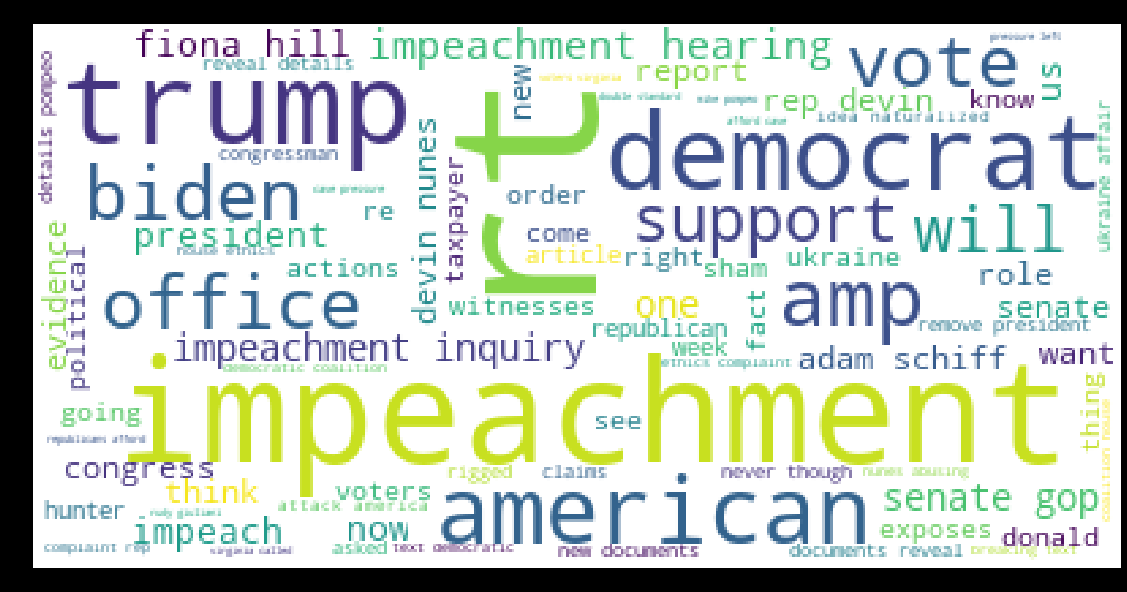

In [15]:
def wordcloud(tweet,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweet[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Impeachment Tweet")
wordcloud(tweet,'tweetText')